In [1]:
import numpy as np
from pathlib import Path
from tqdm import tqdm
from scipy.io import loadmat
import random
import math
from numpy import genfromtxt
import resampy
import matplotlib.pyplot as plt

In [2]:
# this is not where the data is, but where we will save the process
data_root = Path("/home/Students/stg60/DATA/version_1")
data_milton_par = Path("/home/Students/stg60/Data/data/newmats/real/Prediction_project/Milton_for_parameter_est")
data_milton_pred = Path("/home/Students/stg60/Data/data/newmats/real/Prediction_project/Milton_for_prediction")

In [3]:
def read_tsv(tsv, start_index = 1024, end_index = None, scale = True):
    dat = genfromtxt(tsv, delimiter='\t')
    x1,x2,x3,x4,x5,x6 = np.hsplit(dat,6)
    ell_1=((x1-x4)**2+(x2-x5)**2+(x3-x6)**2)**0.5 + 1e-10
    ang_sin_x_1=(x1-x4)/ell_1
    phi =np.arcsin(ang_sin_x_1)*180/np.pi
    phi = phi.reshape(-1)[start_index:end_index]
    x1 = x1.reshape(-1)[start_index:end_index]
    phi = resampy.resample(phi, sr_orig = 250, sr_new = 100)
    x1 = resampy.resample(x1, sr_orig = 250, sr_new = 100)
    if scale:
        phi = phi/20
        x1 = x1/0.335
    return phi, x1

def strides(a, L = 128, S=1):  # Window len = L, Stride len/stepsize = S
    tolist = False
    if isinstance(a, list):
        tolist = True
        a = np.array(a)
    if S is None:
        S = math.ceil(a.size/10)
    nrows = ((a.size - L) // S) + 1
    n = a.strides[0]
    windows = np.lib.stride_tricks.as_strided(a, shape=(nrows, L), strides=(S * n, n))
    
    if tolist:
        windows = windows.tolist()
    return windows

def getAllMats(path = "/data/stg60/newchaos/data/mats/synthetic/folder002/", sample = None, filter_required = True, L = 128, timetopredict = 1.96, samplingrate = 100):
    maxsize = int(timetopredict*samplingrate) + L*4 + 1
    data = sorted(Path(path).glob("milton*.mat"))
    if sample:
        data = random.sample(data, sample)
    if filter_required:
        data = list(filter(lambda x:loadmat(x)['phiv'].max()>20 and loadmat(x)['phiv'].size>maxsize, data))
    return data

100%|██████████| 9/9 [00:01<00:00,  6.71it/s]
9it [00:00, 18.08it/s]


(3637, 128, 4) (3637, 1) 0.48748968930437175


100%|██████████| 5/5 [00:00<00:00, 16.12it/s]
5it [00:00, 17.48it/s]


(2011, 128, 4) (2011, 1) 0.48980606663351567
The sampled sim_path_list is  511


100%|██████████| 486/486 [00:01<00:00, 313.79it/s]


The shape of xtrain is (195200, 128, 4), the ratio of fall/nofall : 0.4904815573770492


100%|██████████| 25/25 [00:00<00:00, 409.33it/s]

The shape of xval is (9926, 128, 4), the ratio of fall/nofall : 0.49617167036066895


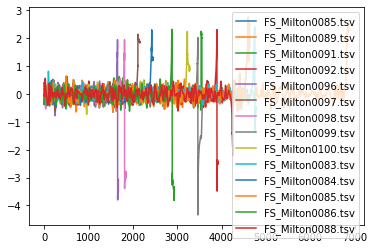

In [4]:
def prepareData(path, cutoff = 128, delay = 23, L = 128, timetopredict = 1.96, samplingrate = 100, fall_stride = 1, start_index = 1024, end_index = None, scale = True):
    """AI is creating summary for prepareData

    Args:
        path ([Str]): [path to the original file]
        cutoff (int, optional): [description]. Defaults to 128.
        delay (int, optional): [description]. Defaults to 23.
        L (int, optional): [Window size]. Defaults to 128.
        timetopredict (float, optional): [description]. Defaults to 1.96.
        samplingrate (int, optional): [description]. Defaults to 100.
        fall_stride (int, optional): [description]. Defaults to 1.
        start_index (int, optional): [description]. Defaults to 1024.
        end_index ([type], optional): [description]. Defaults to None.
        scale (bool, optional): [description]. Defaults to True.
    Returns:
        [type]: [description]

    Yields:
        [type]: [description]
    """
    # timetopredict in seconds, note 1 point = 0.01 seconds, or 100points = 1seconds
    def disect(*args, separator = None):
        for arg in args:
            nofall, fall = arg[:-separator], arg[-separator:]
            yield (nofall, fall)
    
    if path.suffix == ".mat":    
        if not isinstance(path, str):
            path = path.as_posix()
        mat = loadmat(path)
        phiv = mat['phiv'].reshape(-1)
        dxv = mat['dxv'].reshape(-1)
        if scale:
            phiv = phiv/20
            dxv = dxv/0.335
    elif path.suffix == ".tsv":
        phiv, dxv = read_tsv(path, start_index = start_index, end_index=end_index)

    phiv = phiv[:-cutoff]
    dxv = dxv[:-cutoff]

    #phiv -> delay, respo
    delay_phiv = phiv[delay:]
    respo_phiv = phiv[:-delay]

    #dxv -> delay, respo
    delay_dxv = dxv[delay:]
    respo_dxv = dxv[:-delay]

    #fall region
    fall_region = L + int(timetopredict*samplingrate)
    [(n_delay_phiv, f_delay_phiv), (n_respo_phiv, f_respo_phiv)] = disect(delay_phiv, respo_phiv, separator=fall_region)
    [(n_delay_dxv, f_delay_dxv), (n_respo_dxv, f_respo_dxv)] = disect(delay_dxv, respo_dxv, separator=fall_region)

    if n_delay_phiv.size < f_delay_phiv.size:
        S = 1
    else:
        S = math.ceil((n_delay_phiv.size - f_delay_phiv.size)/(timetopredict*samplingrate+1))

    #s=1 for imbalanced
    # no_fall_windows
    n_delay_phiv = strides(n_delay_phiv, L = L, S = S)
    n_respo_phiv = strides(n_respo_phiv, L = L, S = S)
    n_delay_dxv = strides(n_delay_dxv, L = L, S = S)
    n_respo_dxv = strides(n_respo_dxv, L = L, S = S)

    # fall_windows
    f_delay_phiv = strides(f_delay_phiv, L = L, S = fall_stride)
    f_respo_phiv = strides(f_respo_phiv, L = L, S = fall_stride)
    f_delay_dxv = strides(f_delay_dxv, L = L, S = fall_stride)
    f_respo_dxv = strides(f_respo_dxv, L = L, S = fall_stride)

    # concatenate features
    n_x = np.stack((n_delay_phiv,n_respo_phiv,n_delay_dxv,n_respo_dxv), -1)
    f_x = np.stack((f_delay_phiv,f_respo_phiv,f_delay_dxv,f_respo_dxv), -1)

    n_y = np.zeros(n_x.shape[0]).reshape(-1,1)
    f_y = np.ones(f_x.shape[0]).reshape(-1,1)

    x = np.concatenate((n_x,f_x), 0)
    y = np.concatenate((n_y,f_y), 0)

    return x, y, S

def getOneHugeArray(path_list, start_index_list = None, end_index_list = None):
    datax = []
    datay = []
    if start_index_list is None and end_index_list is None:    
        for path in tqdm(path_list):
            x,y,_ = prepareData(path, cutoff = 128, delay = 23, L = 128, timetopredict = 1.96, samplingrate = 100, fall_stride = 1)
            datax.append(x)
            datay.append(y)
    else:
        for path, start_index, end_index in tqdm(zip(path_list, start_index_list, end_index_list)):
            x,y,_ = prepareData(path, cutoff = 128, delay = 23, L = 128, timetopredict = 1.96, samplingrate = 100, fall_stride = 1, start_index = start_index, end_index = end_index)
            datax.append(x)
            datay.append(y)
    x = np.concatenate(datax)    
    y = np.concatenate(datay)

    return x, y

def create_Real_Data(data_path_list, mode = "pred"):
    data_path_list = sorted(data_path_list.glob('*.tsv'))
    start_index_list = [1024]*len(data_path_list)
    end_index_list = [None]*len(data_path_list)
    for x in tqdm(data_path_list):
        phi,_ = read_tsv(x)
        plt.plot(phi, label = x.name)
    plt.legend()
    plt.savefig(f"plots_{mode}.png")

    x, y = getOneHugeArray(data_path_list, start_index_list = start_index_list, end_index_list = end_index_list)

    print(x.shape, y.shape, y.sum()/y.size)

    np.savez(data_root/f"{mode}.npz", x = x, y = y)


#def saveIndividually():
#    sim_path_list = getAllMats(sample=100)
#    train_path_list = sim_path_list[:-10]
#    val_path_list = sim_path_list[-10:]
#
#    data_root.mkdir(exist_ok=True)
#    train_target = data_root/"train"
#    train_target.mkdir(exist_ok = True)
#    val_target = data_root/"val"
#    val_target.mkdir(exist_ok=True)
#
#    savePerSimulation(train_path_list, train_target)
#    savePerSimulation(val_path_list, val_target)
#
#
#    meta = f"""
#    PER SIMULATION WISE, divided int o train and test folder
#    Data is sampled at 100,
#    Train test split is done by taking first 90 for train and 10 for test
#    we use dynamic stride size in fall region
#    no fall region uses only stride = 1
#    windows size = 128
#    data being used are from : simulated :  "/data/stg60/newchaos/data/mats/synthetic",
#    these data are filtered to remove size lesser than 1024 and that doesn't has fall that is angle should be greater than 20deg
#    """
#
#    with open(data_root/"metadata.txt", "w") as f:
#        f.write(meta)

if __name__ == '__main__':
    # """
    create_Real_Data(data_milton_pred, mode = "pred")
    create_Real_Data(data_milton_par, mode = "par")
    # """
    
    sim_path_list = getAllMats(sample=None)
    
    print("The sampled sim_path_list is ", len(sim_path_list))
    #print(sim_path_list)

    train_path_list = sim_path_list[:-int(len(sim_path_list)*0.05)]
    val_path_list = sim_path_list[-int(len(sim_path_list)*0.05):]

    xtrain, ytrain = getOneHugeArray(train_path_list)
    print(f"The shape of xtrain is {xtrain.shape}, the ratio of fall/nofall : {ytrain.sum()/ytrain.size}")
    xval, yval = getOneHugeArray(val_path_list)
    print(f"The shape of xval is {xval.shape}, the ratio of fall/nofall : {yval.sum()/yval.size}")

    data_root.mkdir(exist_ok=True)

    np.savez(data_root/"train.npz", x = xtrain, y = ytrain)
    np.savez(data_root/"val.npz", x = xval, y = yval)

    meta = f"""
    ONE-BIG-DATA for all
    Data is sampled at 100,
    Train test split is done by taking first 90 for train and 10 for test
    we use dynamic stride size in fall region
    no fall region uses only stride = 1
    windows size = 128
    data being used are from : simulated :  "/data/stg60/newchaos/data/mats/synthetic",
    these data are filtered to remove size lesser than 1024 and that doesn't has fall that is angle should be greater than 20deg
    """
    with open(data_root/"metadata.txt", "w") as f:
        f.write(meta)